# Variance Explained

The goal of this notebook is to add a variance explained calculated as
`chi2.ppf(pvalue, df=1)`


In [2]:
import polars as pl
from scipy.stats import chi2
import seaborn as sns


### Load the dataset from previous notebook


In [3]:
lead_variant_maf_dataset = pl.read_parquet("lead-maf-vep/*.parquet")


In [4]:
lead_variant_maf_dataset.shape


(2622098, 19)

In [5]:
lead_variant_maf_dataset.head()


variantId,studyId,studyLocusId,beta,zScore,pValueMantissa,pValueExponent,standardError,finemappingMethod,studyType,credibleSetSize,nSamples,nControls,nCases,majorPopulation,allelefrequencies,vepEffect,majorPopulationAF,majorPopulationMAF
str,str,str,f64,f64,f32,i32,f64,str,str,i32,i32,i32,i32,struct[2],list[struct[2]],struct[3],list[struct[2]],f64
"""10_100011477_C_G""","""gtex_exon_adipose_subcutaneous…","""89d0eb8376a8551e0595f02a2ba424…",0.335197,null,1.613,-8,0.058476,"""SuSie""","""eqtl""",14,581,null,null,"{""nfe"",0.0}","[{""sas_adj"",0.140307}, {""remaining_adj"",0.236942}, … {""afr_adj"",0.156099}]","{""upstream_gene_variant"",0.0,null}","[{""nfe_adj"",0.291447}]",0.291447
"""10_100011477_C_G""","""gtex_exon_nerve_tibial_ensg000…","""cbae94dbdf2ce21c8aaae9d88d1f1e…",0.222984,null,3.257,-8,0.0397304,"""SuSie""","""eqtl""",66,532,null,null,"{""nfe"",0.0}","[{""sas_adj"",0.140307}, {""remaining_adj"",0.236942}, … {""afr_adj"",0.156099}]","{""upstream_gene_variant"",0.0,null}","[{""nfe_adj"",0.291447}]",0.291447
"""10_100019534_G_GAA""","""blueprint_exon_monocyte_ensg00…","""b14db85f5fe52358fa03809bdb0db2…",-1.11197,null,2.4,-7,0.206856,"""SuSie""","""eqtl""",1,191,null,null,"{""nfe"",0.0}","[{""sas_adj"",0.071227}, {""remaining_adj"",0.075368}, … {""afr_adj"",0.189559}]","{""upstream_gene_variant"",0.0,null}","[{""nfe_adj"",0.03903}]",0.03903
"""10_100063173_T_G""","""gtex_exon_spleen_ensg000000954…","""7f24212f9828dd4d13b848e3fbac0d…",0.412732,null,1.602,-7,0.0761278,"""SuSie""","""eqtl""",43,227,null,null,"{""nfe"",0.0}","[{""sas_adj"",0.14102}, {""remaining_adj"",0.340133}, … {""afr_adj"",0.189902}]","{""intron_variant"",0.1,null}","[{""nfe_adj"",0.395246}]",0.395246
"""10_100111179_C_T""","""gtex_exon_brain_hippocampus_en…","""8dc7e55aa3a2982bf689175d673d78…",-0.311703,null,6.748,-6,0.0668019,"""SuSie""","""eqtl""",88,165,null,null,"{""nfe"",0.0}","[{""sas_adj"",0.149263}, {""remaining_adj"",0.340364}, … {""afr_adj"",0.28714}]","{""intron_variant"",0.1,null}","[{""nfe_adj"",0.361636}]",0.361636


### Calculate variance explained


In [6]:
def variance_explained(p_value_mantissa: pl.Expr, p_value_exponent: pl.Expr, n_samples: pl.Expr) -> pl.Expr:
    """Estimate the variance explained by the lead variant in a dataset.

    # NOTE! Calculate variance explained requires removal of the studies that have nSamples = 0
    """
    p_value = (p_value_mantissa.cast(pl.Float64()) * pl.lit(10).pow(p_value_exponent.cast(pl.Float64()))).alias(
        "pValue"
    )
    neglog_pval = -1 * p_value_mantissa.log10() + p_value_exponent
    neglog_approximation_intercept = -5.367
    neglog_approximation_coeff = 4.596
    chi2_stat = (
        pl.when(p_value_exponent < -300)
        .then(neglog_pval * neglog_approximation_coeff + neglog_approximation_intercept)
        .otherwise(p_value.map_elements(lambda x: chi2.isf(x, df=1), pl.Float64()))
    ).alias("chi2Stat")
    variance_exp = (chi2_stat / n_samples).alias("varianceExplained")

    return pl.struct(chi2_stat, p_value, variance_exp).alias("leadVariantStats")


In [ ]:
df = lead_variant_maf_dataset.filter(pl.col("nSamples").is_not_null() | pl.col("nSamples") > 0).select(
    "*",
    variance_explained(
        pl.col("pValueMantissa"),
        pl.col("pValueExponent"),
        pl.col("nSamples"),
    ),
)
df.write_parquet("lead-maf-vep-ve.parquet")


In [ ]:
lead_variant_maf_dataset.shape[0] - df.shape[0]


1050

Exactly 1050 samples have no `nSamples` disallowing us to calculate the varianceExplained


## Rescale marginal effect size


For very small p-values it is 

In [ ]:
exponents = list(range(len(10, 300, step=10)))
import math


def neglog_pval(pval: float) -> float:
    return -1 * math.log(pval)


# def estimate_chi2_from_neglog10_pval(neg)
# est_chi2_from_high_neg_log10_pval=function(neg_log10_pval)
#   chi2=neg_log10_pval*4.596-5.367
#   chi2

p_vals = [math.pow(10, -1 * e) for e in exponents]
chi2_stats = [chi2.isf(pval) for pval in p_vals]
sns.scatterplot(
    chi2_stats,
)


In [7]:
def rescale_beta(
    beta: pl.Expr,
    n_cases: pl.Expr,
    n_controls: pl.Expr,
    n_samples: pl.Expr,
    p_value_mantissa: pl.Expr,
    p_value_exponent: pl.Expr,
    maf: pl.Expr,
) -> pl.Expr:
    """Rescale beta to be between 0 and 1."""
    neglog_approximation_intercept = -5.367
    neglog_approximation_coeff = 4.596
    trait_class = (
        pl.when(n_cases.is_null())
        .then(pl.lit("quantitative"))
        .when((n_cases == 0) | (n_controls == 0))
        .then(pl.lit("quantitative"))
        .otherwise(pl.lit("binary"))
    )
    p_value = (p_value_mantissa.cast(pl.Float64()) * pl.lit(10).pow(p_value_exponent.cast(pl.Float64()))).alias(
        "pValue"
    )
    neglog_pval = -1 * p_value_mantissa.log10() + p_value_exponent
    n_samples = pl.when(trait_class == "quantitative").then(n_samples).otherwise(n_cases + n_controls)
    # Calculate the chi2 value - the calculation has to be approximated to the -neglog pval in case when exponent is very low
    # otherwise the chi2 will be infinity. The approximate model metrics are based on the following assumptions.
    chi2_stat = (
        pl.when(p_value_exponent < -300)
        .then(neglog_pval * neglog_approximation_coeff + neglog_approximation_intercept)
        .otherwise(p_value.map_elements(lambda x: chi2.isf(x, df=1), pl.Float64()))
    )
    # In case beta is positive or not reported we use 1 as a sign
    effect_direction = pl.when(beta < 0).then(pl.lit(-1)).otherwise(pl.lit(1))
    z_score = effect_direction * chi2_stat.sqrt()
    var_g = 2 * maf * (1 - maf)
    prev = n_cases / (n_cases + n_controls)
    se = (
        pl.when(trait_class == "quantitative")
        .then((1 / var_g * n_samples).sqrt())
        .otherwise(1 / (var_g * n_samples * prev * (1 - prev)).sqrt())
    )
    new_beta = z_score * se

    return pl.struct(
        new_beta.alias("estimatedBeta"),
        trait_class.alias("traitClass"),
        chi2_stat.alias("chi2Stat"),
        se.alias("estimatedSE"),
        var_g.alias("varG"),
        prev.alias("prev"),
        n_samples.alias("nSamples"),
    ).alias("rescaledStatistics")


In [8]:
df2 = df.select(
    "*",
    rescale_beta(
        pl.col("beta"),
        pl.col("nCases"),
        pl.col("nControls"),
        pl.col("nSamples"),
        pl.col("pValueMantissa"),
        pl.col("pValueExponent"),
        pl.col("majorPopulationMAF"),
    ),
)


In [9]:
df3 = df2.filter(pl.col("majorPopulationMAF") > 0.0).filter(
    pl.col("rescaledStatistics").struct.field("estimatedBeta").is_infinite()
)
df2.shape[0] - df3.shape[0]


2621048

In [ ]:
# Write the dataset
df2.write_parquet("lead-maf-vep-rescaled-beta-ve.parquet")


<Axes: xlabel='majorPopulationMAF', ylabel='estimatedBeta'>

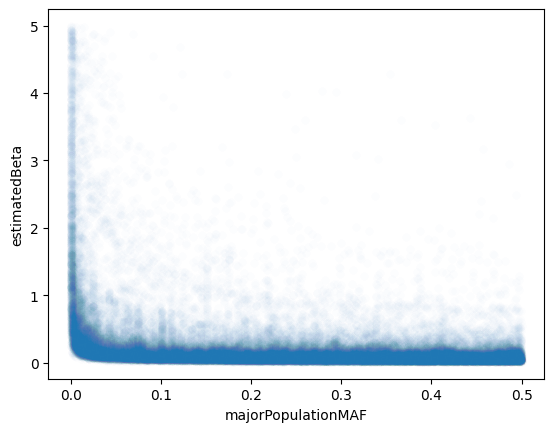

In [14]:
# plot est beta vs maf

import seaborn as sns

df2 = pl.read_parquet("lead-maf-vep-rescaled-beta-ve.parquet")

data = df2.select(
    pl.col("majorPopulationMAF"), pl.col("rescaledStatistics").struct.field("estimatedBeta").abs(), pl.col("studyType")
).filter(pl.col("estimatedBeta") < 5)
sns.scatterplot(data, x="majorPopulationMAF", y="estimatedBeta", alpha=0.01)


In [ ]:
df2.head()


variantId,studyId,studyLocusId,beta,zScore,pValueMantissa,pValueExponent,standardError,finemappingMethod,studyType,credibleSetSize,nSamples,nControls,nCases,majorPopulation,allelefrequencies,vepEffect,majorPopulationAF,majorPopulationMAF,leadVariantStats,rescaledStatistics
str,str,str,f64,f64,f32,i32,f64,str,str,i32,i32,i32,i32,struct[2],list[struct[2]],struct[3],list[struct[2]],f64,struct[3],struct[7]
"""10_100011477_C_G""","""gtex_exon_adipose_subcutaneous…","""89d0eb8376a8551e0595f02a2ba424…",0.335197,null,1.613,-8,0.058476,"""SuSie""","""eqtl""",14,581,null,null,"{""nfe"",0.0}","[{""sas_adj"",0.140307}, {""remaining_adj"",0.236942}, … {""afr_adj"",0.156099}]","{""upstream_gene_variant"",0.0,null}","[{""nfe_adj"",0.291447}]",0.291447,"{31.912211,1.6130e-8,0.054926}","{211.877795,""quantitative"",31.912211,37.50654,0.413011,null,581}"
"""10_100011477_C_G""","""gtex_exon_nerve_tibial_ensg000…","""cbae94dbdf2ce21c8aaae9d88d1f1e…",0.222984,null,3.257,-8,0.0397304,"""SuSie""","""eqtl""",66,532,null,null,"{""nfe"",0.0}","[{""sas_adj"",0.140307}, {""remaining_adj"",0.236942}, … {""afr_adj"",0.156099}]","{""upstream_gene_variant"",0.0,null}","[{""nfe_adj"",0.291447}]",0.291447,"{30.548044,3.2570e-8,0.057421}","{198.365645,""quantitative"",30.548044,35.890107,0.413011,null,532}"
"""10_100019534_G_GAA""","""blueprint_exon_monocyte_ensg00…","""b14db85f5fe52358fa03809bdb0db2…",-1.11197,null,2.4,-7,0.206856,"""SuSie""","""eqtl""",1,191,null,null,"{""nfe"",0.0}","[{""sas_adj"",0.071227}, {""remaining_adj"",0.075368}, … {""afr_adj"",0.189559}]","{""upstream_gene_variant"",0.0,null}","[{""nfe_adj"",0.03903}]",0.03903,"{26.680755,2.4000e-7,0.13969}","{-260.641789,""quantitative"",26.680755,50.459737,0.075014,null,191}"
"""10_100063173_T_G""","""gtex_exon_spleen_ensg000000954…","""7f24212f9828dd4d13b848e3fbac0d…",0.412732,null,1.602,-7,0.0761278,"""SuSie""","""eqtl""",43,227,null,null,"{""nfe"",0.0}","[{""sas_adj"",0.14102}, {""remaining_adj"",0.340133}, … {""afr_adj"",0.189902}]","{""intron_variant"",0.1,null}","[{""nfe_adj"",0.395246}]",0.395246,"{27.462141,1.6020e-7,0.120979}","{114.193674,""quantitative"",27.462141,21.790884,0.478053,null,227}"
"""10_100111179_C_T""","""gtex_exon_brain_hippocampus_en…","""8dc7e55aa3a2982bf689175d673d78…",-0.311703,null,6.748,-6,0.0668019,"""SuSie""","""eqtl""",88,165,null,null,"{""nfe"",0.0}","[{""sas_adj"",0.149263}, {""remaining_adj"",0.340364}, … {""afr_adj"",0.28714}]","{""intron_variant"",0.1,null}","[{""nfe_adj"",0.361636}]",0.361636,"{20.263376,0.000007,0.122808}","{-85.09672,""quantitative"",20.263376,18.904139,0.461711,null,165}"


# How many rare variants come from GWAS only vs 

In [ ]:
n_rare_var_all = (
    lead_variant_maf_dataset.filter(pl.col("majorPopulationMAF").is_not_null())
    .filter(pl.col("majorPopulationMAF") != 0.0)
    .filter(pl.col("majorPopulationMAF") < 0.01)
    .shape[0]
)
n_all = (
    lead_variant_maf_dataset.filter(pl.col("majorPopulationMAF").is_not_null())
    .filter(pl.col("majorPopulationMAF") != 0.0)
    .shape[0]
)
n_rare_var_gwas = (
    lead_variant_maf_dataset.filter(pl.col("studyType") == "gwas")
    .filter(pl.col("majorPopulationMAF").is_not_null())
    .filter(pl.col("majorPopulationMAF") != 0.0)
    .filter(pl.col("majorPopulationMAF") < 0.01)
    .shape[0]
)

n_all_gwas = (
    lead_variant_maf_dataset.filter(pl.col("studyType") == "gwas")
    .filter(pl.col("majorPopulationMAF").is_not_null())
    .filter(pl.col("majorPopulationMAF") != 0.0)
    .shape[0]
)

print(f"all {n_rare_var_all}")
print(f"gwas {n_rare_var_gwas}")


print(f"")


all 120617
gwas 40186


In [ ]:
_all = (
    lead_variant_maf_dataset.select(
        pl.when((pl.col("majorPopulationMAF").is_not_null()) & (pl.col("majorPopulationMAF") > 0.01))
        .then(1)
        .otherwise(0)
        .alias("rareAllCs")
    )
    .group_by("rareAllCs")
    .len()
    .to_pandas()
    .rename(columns={"len": "AllCs", "rareAllCs": "group"})
    .set_index("group")
)
_gwas = (
    lead_variant_maf_dataset.filter(pl.col("studyType") == "gwas")
    .select(
        pl.when((pl.col("majorPopulationMAF").is_not_null()) & (pl.col("majorPopulationMAF") > 0.01))
        .then(1)
        .otherwise(0)
        .alias("rareGWASCs")
    )
    .group_by("rareGWASCs")
    .len()
    .to_pandas()
    .rename(columns={"len": "GWASCs", "rareGWASCs": "group"})
    .set_index("group")
)


print(_gwas)
_all.join(_gwas)


       GWASCs
group        
0       44714
1      532757


,AllCs,GWASCs
group,,
0,126063,44714
1,2496035,532757


In [ ]:
from scipy.stats.contingency import odds_ratio

res = odds_ratio(_all.join(_gwas))
print(res.statistic, res.confidence_interval(0.95))


0.6017591305270131 ConfidenceInterval(low=0.5950592515706303, high=0.6085421666812814)


1. GWAS releated creadible sets devide by quatatave and binary 

When rescaled abs(beta) > 3 (exclude from analysis)

2 plots
* abs(beta) / mean allele freq
* novel vs known


2 plots
* square beta vs maf(1-maf)


2. for binary traits (GWAS only) how many have rescaled beta > 1 > 2 > 3 >
3. for binary traits (exclude abs(beta) > 3), use non abs beta, swap the beta sign in case the AF > 0.5 -> histogram

4. send the file


pleiotropicity on variant level!
